Function

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

class FeatureExtractor:
    def __init__(self, normal_ratio=0.5, abnormal_ratio=0.5):
        assert normal_ratio + abnormal_ratio == 1, "The sum of normal_ratio and abnormal_ratio must be 1."
        self.normal_ratio = normal_ratio
        self.abnormal_ratio = abnormal_ratio

    def calculate_features(self, data):
        Z1 = np.mean(np.abs(data))  #  (Mean Value)
        Z2 = np.sqrt(np.mean(data ** 2))  # RMS
        Z3 = np.std(data)  # Standard Deviation
        Z4 = Z2 / Z1  # Shape Factor
        Z5 = np.mean(((np.abs(data - Z1)) / Z3) ** 3)  # Skewness
        Z6 = np.mean(((np.abs(data - Z1)) / Z3) ** 4)  # Kurtosis
        Z7 = np.max(np.abs(data))  # Peak Value
        Z8 = Z7 / Z2  # Crest Factor
        Z9 = Z7 / Z1  # Impulse Factor
        Z10 = np.sum([(f ** 2) * p for f, p in enumerate(np.abs(np.fft.fft(data)) ** 2)])  #  (MSF)
        Z11 = np.mean(np.abs(np.fft.fft(data)) ** 2)  # (MPS)
        Z12 = np.sum([f * p for f, p in enumerate(np.abs(np.fft.fft(data)) ** 2)]) / np.sum(np.abs(np.fft.fft(data)) ** 2)  # (FC)
        return [Z1, Z2, Z3, Z4, Z5, Z6, Z7, Z8, Z9, Z10, Z11, Z12]

    def extract_features(self, expt_data):
        normal_features = []
        abnormal_features = []

        for key, df in expt_data.items():  # (Accelerometer, Force, Acoustic)
            n_normal = int(len(df) * self.normal_ratio)
            n_abnormal = len(df) - n_normal

            normal_data = df.iloc[:n_normal]
            abnormal_data = df.iloc[-n_abnormal:]

            for col in df.columns:
                normal_features.append(self.calculate_features(normal_data[col]))
                abnormal_features.append(self.calculate_features(abnormal_data[col]))

        normal_features = np.array(normal_features).flatten()
        abnormal_features = np.array(abnormal_features).flatten()

        return normal_features, abnormal_features

    def t_test_features(self, normal_features, abnormal_features):
        t_stat, p_value = ttest_ind(normal_features, abnormal_features, equal_var=False)
        return {'t_stat': t_stat, 'p_value': p_value}

    def process_experiment(self, experiment_data):
        feature_results = {}
        t_test_results = {}

        for expt_name, expt_data in experiment_data.items():
            normal_features, abnormal_features = self.extract_features(expt_data)
            feature_results[expt_name] = {'normal': normal_features, 'abnormal': abnormal_features}
            t_test_results[expt_name] = self.t_test_features(normal_features, abnormal_features)

        return feature_results, t_test_results



In [ ]:
def load_experiment_data(directory_path):
    # Define the names of the data folders and the label folder
    data_folders = ["Accelerometer_Data", "Force_Data", "Acoustic_Emission_Data"]
    label_folder = "Tool_wear_values"

    # Initialize a dictionary to store dataframes for each experiment
    experiment_data = {}

    # Loop through each experiment number
    for i in range(1, 13):
        experiment_name = f"Expt_{i}"
        experiment_data[experiment_name] = {}

        # Loop through each data folder and load the corresponding CSV
        for folder in data_folders:
            csv_path = os.path.join(directory_path, folder, f"{experiment_name}.csv")
            df = pd.read_csv(csv_path)
            experiment_data[experiment_name][folder] = df

    return experiment_data

t-test(find for prognostic)

In [ ]:
import os
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

# 데이터 로드 및 결합 함수 (센서별로 데이터 결합)
def load_and_combine_experiment_data(directory_path):
    data_folders = ["Accelerometer_Data", "Force_Data", "Acoustic_Emission_Data"]
    combined_data = {'Accelerometer': [], 'Force': [], 'Acoustic': []}

    # 각 실험 Expt_1 ~ Expt_12 데이터를 결합
    for i in range(1, 13):
        experiment_name = f"Expt_{i}"
        for folder in data_folders:
            csv_path = os.path.join(directory_path, folder, f"{experiment_name}.csv")
            df = pd.read_csv(csv_path)

            # 센서별 데이터 결합
            if folder == "Accelerometer_Data":
                combined_data['Accelerometer'].append(df)  # x, y, z (3개)
            elif folder == "Force_Data":
                combined_data['Force'].append(df)  # force 센서 (3개)
            elif folder == "Acoustic_Emission_Data":
                combined_data['Acoustic'].append(df)  # Acoustic (1개)

    # 실험 데이터를 각 센서별로 결합
    combined_data['Accelerometer'] = pd.concat(combined_data['Accelerometer'], axis=0).reset_index(drop=True)
    combined_data['Force'] = pd.concat(combined_data['Force'], axis=0).reset_index(drop=True)
    combined_data['Acoustic'] = pd.concat(combined_data['Acoustic'], axis=0).reset_index(drop=True)

    return combined_data

# 2. Feature extraction and t-test
class FeatureExtractor:
    def __init__(self):
        pass

    def calculate_features(self, data):
        Z1 = np.mean(np.abs(data))  # Mean Value
        Z2 = np.sqrt(np.mean(data ** 2))  # RMS
        Z3 = np.std(data)  # Standard Deviation
        Z4 = Z2 / Z1 if Z1 != 0 else 0  # Shape Factor
        Z5 = np.mean(((np.abs(data - Z1)) / Z3) ** 3) if Z3 != 0 else 0  # Skewness
        Z6 = np.mean(((np.abs(data - Z1)) / Z3) ** 4) if Z3 != 0 else 0  # Kurtosis
        Z7 = np.max(np.abs(data))  # Peak Value
        Z8 = Z7 / Z2 if Z2 != 0 else 0  # Crest Factor
        Z9 = Z7 / Z1 if Z1 != 0 else 0  # Impulse Factor
        fft_vals = np.abs(np.fft.fft(data)) ** 2
        Z10 = np.sum([(f ** 2) * p for f, p in enumerate(fft_vals)]) if np.sum(fft_vals) != 0 else 0  # MSF
        Z11 = np.mean(fft_vals)  # MPS
        Z12 = np.sum([f * p for f, p in enumerate(fft_vals)]) / np.sum(fft_vals) if np.sum(fft_vals) != 0 else 0  # FC

        return [Z1, Z2, Z3, Z4, Z5, Z6, Z7, Z8, Z9, Z10, Z11, Z12]

    def extract_features(self, data):
        features = []
        for col in data.columns:
            features.append(self.calculate_features(data[col]))
        features_flat = np.array(features).flatten()
        return features_flat

    def t_test_features(self, normal_features, abnormal_features):
        t_stat, p_value = ttest_ind(normal_features, abnormal_features, equal_var=False)
        return {'t_stat': t_stat, 'p_value': p_value}

# 3. 센서 데이터를 각각 비율에 따라 나누고 특징 추출
def find_optimal_ratio_for_each_sensor(combined_data, ratios):
    feature_extractor = FeatureExtractor()
    min_avg_p_value = float('inf')
    optimal_ratio = 0
    p_values_dict = {}

    for ratio in ratios:
        total_normal_features = []
        total_abnormal_features = []

        # 각 센서별로 데이터를 나누고 특징을 추출
        for sensor_type, data in combined_data.items():
            n_normal = int(len(data) * ratio)
            n_abnormal = len(data) - n_normal

            # 비율에 따라 데이터 분리
            normal_data = data.iloc[:n_normal]
            abnormal_data = data.iloc[-n_abnormal:]

            # 각 센서별로 특징 추출
            normal_features = feature_extractor.extract_features(normal_data)
            abnormal_features = feature_extractor.extract_features(abnormal_data)

            # 각 센서의 특징을 결합
            total_normal_features.extend(normal_features)
            total_abnormal_features.extend(abnormal_features)

        # t-test 수행
        t_test_result = feature_extractor.t_test_features(total_normal_features, total_abnormal_features)
        avg_p_value = t_test_result['p_value']

        p_values_dict[ratio] = avg_p_value

        # 최소 p-value와 그에 해당하는 비율 추적
        if avg_p_value < min_avg_p_value:
            min_avg_p_value = avg_p_value
            optimal_ratio = ratio

    return optimal_ratio, min_avg_p_value, p_values_dict

# 4. Main code to process each T1~T8
directories = [f'/content/drive/MyDrive/COOP/0814_은수님작업연장/Dataset/T{i}' for i in range(1, 9)]
ratios = np.arange(0.5, 1.0, 0.1)  # 0.5부터 0.9까지의 비율

for i, directory_path in enumerate(directories, 1):
    print(f"Processing T{i}...")

    # 센서별 데이터 로드 및 결합
    combined_data = load_and_combine_experiment_data(directory_path)

    # 각 센서에 대해 비율을 적용하고, 그에 따른 최적의 비율을 찾음
    optimal_ratio, min_avg_p_value, p_values_dict = find_optimal_ratio_for_each_sensor(combined_data, ratios)

    # 결과 출력
    print(f"T{i} Optimal Normal Ratio: {optimal_ratio}")
    print(f"T{i} Minimum Average p-value: {min_avg_p_value}")
    print(f"T{i} Average p-values per ratio:")

    for ratio, avg_p_value in p_values_dict.items():
        print(f"Normal Ratio: {ratio}, Average p-value: {avg_p_value}")

    print("\n" + "="*50 + "\n")


Processing T1...
T1 Optimal Normal Ratio: 0.8999999999999999
T1 Minimum Average p-value: 0.10209103936227325
T1 Average p-values per ratio:
Normal Ratio: 0.5, Average p-value: 0.20097589309173058
Normal Ratio: 0.6, Average p-value: 0.9961365334057536
Normal Ratio: 0.7, Average p-value: 0.14770940382062606
Normal Ratio: 0.7999999999999999, Average p-value: 0.10751198885907262
Normal Ratio: 0.8999999999999999, Average p-value: 0.10209103936227325


Processing T2...
T2 Optimal Normal Ratio: 0.8999999999999999
T2 Minimum Average p-value: 0.04894018939849554
T2 Average p-values per ratio:
Normal Ratio: 0.5, Average p-value: 0.9949906756280661
Normal Ratio: 0.6, Average p-value: 0.1839820472750449
Normal Ratio: 0.7, Average p-value: 0.0740514101125444
Normal Ratio: 0.7999999999999999, Average p-value: 0.05417358091502553
Normal Ratio: 0.8999999999999999, Average p-value: 0.04894018939849554


Processing T3...
T3 Optimal Normal Ratio: 0.8999999999999999
T3 Minimum Average p-value: 0.114322313

Processing T1...
T1 Optimal Normal Ratio: 0.9800000000000004
T1 Minimum Average p-value: 0.1005759101823177
T1 Average p-values per ratio:
Normal Ratio: 0.5, Average p-value: 0.20097589309173058
Normal Ratio: 0.52, Average p-value: 0.2500142834746695
Normal Ratio: 0.54, Average p-value: 0.3311676337770142
Normal Ratio: 0.56, Average p-value: 0.4663054792122303
Normal Ratio: 0.5800000000000001, Average p-value: 0.6889090812818395
Normal Ratio: 0.6000000000000001, Average p-value: 0.9961365334057536
Normal Ratio: 0.6200000000000001, Average p-value: 0.6681092155653725
Normal Ratio: 0.6400000000000001, Average p-value: 0.43006098646392776
Normal Ratio: 0.6600000000000001, Average p-value: 0.28715813993209777
Normal Ratio: 0.6800000000000002, Average p-value: 0.20093665676198538
Normal Ratio: 0.7000000000000002, Average p-value: 0.14770940382062606
Normal Ratio: 0.7200000000000002, Average p-value: 0.11878107342447401
Normal Ratio: 0.7400000000000002, Average p-value: 0.11008589306200042
N

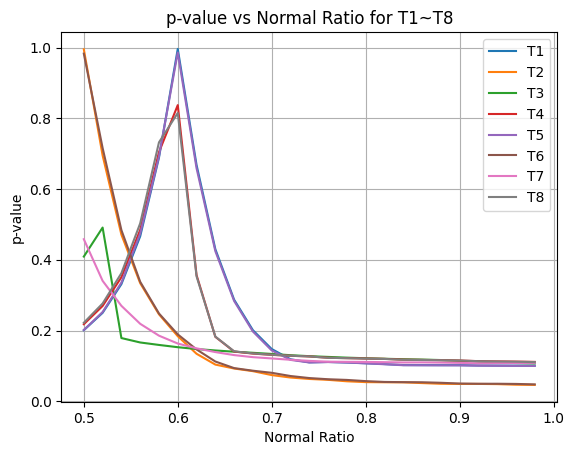

In [ ]:
ratios = np.arange(0.5, 1.0, 0.02)  # 0.5부터 0.98까지의 비율

# 센서별 데이터를 로드하고 처리하는 함수들 (가정: 기존 코드에서 이미 정의되어 있음)
# directories, load_and_combine_experiment_data, find_optimal_ratio_for_each_sensor 등이 정의된 상태

# 결과를 저장할 리스트
p_values_dict_list = []

# Main code to process each T1~T8
for i, directory_path in enumerate(directories, 1):
    print(f"Processing T{i}...")

    # 센서별 데이터 로드 및 결합
    combined_data = load_and_combine_experiment_data(directory_path)

    # 각 센서에 대해 비율을 적용하고, 그에 따른 최적의 비율을 찾음
    optimal_ratio, min_avg_p_value, p_values_dict = find_optimal_ratio_for_each_sensor(combined_data, ratios)

    # 결과 저장
    p_values_dict_list.append(p_values_dict)

    # 결과 출력
    print(f"T{i} Optimal Normal Ratio: {optimal_ratio}")
    print(f"T{i} Minimum Average p-value: {min_avg_p_value}")
    print(f"T{i} Average p-values per ratio:")

    for ratio, avg_p_value in p_values_dict.items():
        print(f"Normal Ratio: {ratio}, Average p-value: {avg_p_value}")

    print("\n" + "="*50 + "\n")

# 시각화: x축은 ratio, y축은 p-value
for i, p_values_dict in enumerate(p_values_dict_list, 1):
    plt.plot(ratios, [p_values_dict[ratio] for ratio in ratios], label=f"T{i}")

# 그래프 설정
plt.xlabel("Normal Ratio")
plt.ylabel("p-value")
plt.title("p-value vs Normal Ratio for T1~T8")
plt.legend()
plt.grid(True)
plt.show()

Toolwear augmentation

In [ ]:
import os
import pandas as pd
import numpy as np

TYPE1(모든 T1~T8 동일한 길이 가정)

In [ ]:
def toolwear_augmentation(directory_path):
    # Initialize a dictionary to store the extended data
    extended_data = {}

    # Loop through each folder T1~T8
    for folder in ["T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8"]:
        # Construct the path for the Tool_Wear_Value folder inside each T1~T8 folder
        tool_wear_folder = os.path.join(directory_path, folder, "Tool_Wear_Values")
        csv_file_name = f"{folder}_Tool_wear_values_for_all_Experiments.csv"
        csv_path = os.path.join(tool_wear_folder, csv_file_name)

        # Try loading the CSV file with different encodings
        try:
            df = pd.read_csv(csv_path, encoding='latin1')
        except UnicodeDecodeError:
            print(f"UnicodeDecodeError with 'latin1', retrying with 'cp1252' for {csv_file_name}")
            df = pd.read_csv(csv_path, encoding='cp1252')

        # Extract the tool wear values from the second column (Tool Wear in (µm))
        tool_wear_values = df.iloc[:, 1].values  # 두 번째 열에서 데이터를 가져옴

        # Check if we have at least 2 values to proceed
        if len(tool_wear_values) < 2:
            print(f"Not enough data in {csv_file_name}. Skipping this file.")
            continue  # Skip this iteration if there are not enough values

        # Initialize a list to store the extended values for each experiment
        extended_values = []

        # (1) Add 99 values before Expt_1 based on Expt_1 and Expt_2 difference
        expt_1 = tool_wear_values[0]
        expt_2 = tool_wear_values[1]
        diff = expt_2 - expt_1
        values_before_expt1 = np.exp(np.linspace(np.log(expt_1 - diff), np.log(expt_1), 99))
        extended_values.extend(values_before_expt1)  # Append 99 previous values

        # Append Expt_1 value
        extended_values.append(expt_1)

        # (2) Generate exactly 99 intermediate values between each pair (Expt_1 ~ Expt_12)
        for i in range(len(tool_wear_values) - 1):
            start_value = tool_wear_values[i]
            end_value = tool_wear_values[i + 1]

            # Generate 99 intermediate values, excluding the last point to avoid duplication
            intermediate_values = np.exp(np.linspace(np.log(start_value), np.log(end_value), 100))[:-1]

            # Append the intermediate values and the original value (Expt_2, Expt_3, ...)
            extended_values.extend(intermediate_values)
            extended_values.append(end_value)  # Explicitly append the original next value

        # (3) Final check: Ensure we have exactly 1200 values
        if len(extended_values) != 1200:
            print(f"Error: Expected 1200 values, but got {len(extended_values)} values for {folder}")
        else:
            print(f"Success: Generated 1200 values for {folder}")

        # Convert the extended values into a DataFrame and store it
        extended_df = pd.DataFrame(extended_values, columns=['Tool Wear in (µm)'])
        extended_data[folder] = extended_df

        # Save the extended data to a new CSV file (optional)
        extended_csv_path = os.path.join(tool_wear_folder, f"{folder}_extended_Tool_wear_values.csv")
        extended_df.to_csv(extended_csv_path, index=False)

    return extended_data


In [ ]:
directory_path = "/content/drive/MyDrive/COOP/0814_은수님작업연장/Dataset"
extended_data = toolwear_augmentation(directory_path)


Success: Generated 1200 values for T1
Success: Generated 1200 values for T2
Success: Generated 1200 values for T3
Success: Generated 1200 values for T4
Success: Generated 1200 values for T5
Success: Generated 1200 values for T6
Success: Generated 1200 values for T7
Success: Generated 1200 values for T8


In [ ]:
extended_data

{'T1':       Tool Wear in (µm)
 0            102.472000
 1            102.666073
 2            102.860514
 3            103.055323
 4            103.250501
 ...                 ...
 1195         305.830463
 1196         305.985230
 1197         306.140075
 1198         306.294998
 1199         306.450000
 
 [1200 rows x 1 columns],
 'T2':       Tool Wear in (µm)
 0            103.307080
 1            103.472830
 2            103.638846
 3            103.805128
 4            103.971677
 ...                 ...
 1195         311.443256
 1196         311.726804
 1197         312.010611
 1198         312.294676
 1199         312.579000
 
 [1200 rows x 1 columns],
 'T3':       Tool Wear in (µm)
 0             80.561000
 1             80.840742
 2             81.121456
 3             81.403145
 4             81.685811
 ...                 ...
 1195         319.565546
 1196         319.827587
 1197         320.089843
 1198         320.352314
 1199         320.615000
 
 [1200 rows x 1 columns]

In [ ]:
import pandas as pd

def merge_extended_data_to_columns(extended_data, output_csv_path):
    # Initialize an empty DataFrame
    merged_df = pd.DataFrame()

    # Loop through each folder and its corresponding dataframe
    for folder, df in extended_data.items():
        # Add the data as a new column to the merged_df DataFrame
        merged_df[folder] = df['Tool Wear in (µm)']

    # Save the merged dataframe to a CSV file
    merged_df.to_csv(output_csv_path, index=False)

    print(f"Data saved to {output_csv_path}")

# Example usage: specify the output CSV file path
output_csv_path = '/content/drive/MyDrive/COOP/toolwear_all/TYPE1_exp.csv'
merge_extended_data_to_columns(extended_data, output_csv_path)


Data saved to /content/drive/MyDrive/COOP/toolwear_all/TYPE1_exp.csv


TYPE2(모든 T 다르게 시간 설정)

In [ ]:
import os
import numpy as np
import pandas as pd

def TYPE2_augmentation(directory_path):
    # Initialize a dictionary to store the extended data
    extended_data = {}

    # Define the number of additional values to add for each folder
    additional_values_map = {
        "T1": 107, "T5": 107,  # T1, T5
        "T2": 75, "T6": 75,    # T2, T6
        "T3": 55, "T7": 55,    # T3, T7
        "T4": 39, "T8": 39     # T4, T8
    }

    # Define the expected total length for each folder
    expected_length_map = {
        "T1": 1296, "T5": 1296,  # T1, T5
        "T2": 912,  "T6": 912,   # T2, T6
        "T3": 672,  "T7": 672,   # T3, T7
        "T4": 480,  "T8": 480    # T4, T8
    }

    # Loop through each folder T1~T8
    for folder in ["T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8"]:
        # Construct the path for the Tool_Wear_Value folder inside each T1~T8 folder
        tool_wear_folder = os.path.join(directory_path, folder, "Tool_Wear_Values")
        csv_file_name = f"{folder}_Tool_wear_values_for_all_Experiments.csv"
        csv_path = os.path.join(tool_wear_folder, csv_file_name)

        # Try loading the CSV file with different encodings
        try:
            df = pd.read_csv(csv_path, encoding='latin1')
        except UnicodeDecodeError:
            print(f"UnicodeDecodeError with 'latin1', retrying with 'cp1252' for {csv_file_name}")
            df = pd.read_csv(csv_path, encoding='cp1252')

        # Extract the tool wear values from the second column (Tool Wear in (µm))
        tool_wear_values = df.iloc[:, 1].values  # 두 번째 열에서 데이터를 가져옴

        # Check if we have at least 2 values to proceed
        if len(tool_wear_values) < 2:
            print(f"Not enough data in {csv_file_name}. Skipping this file.")
            continue  # Skip this iteration if there are not enough values

        # Get the number of additional values to add based on the folder
        additional_values = additional_values_map[folder]

        # Initialize a list to store the extended values for each experiment
        extended_values = []

        # (1) Add 'additional_values' before Expt_1 based on Expt_1 and Expt_2 difference
        expt_1 = tool_wear_values[0]
        expt_2 = tool_wear_values[1]
        diff = expt_2 - expt_1
        values_before_expt1 = np.exp(np.linspace(np.log(expt_1 - diff), np.log(expt_1), additional_values))
        extended_values.extend(values_before_expt1)  # Append the additional previous values

        # Append Expt_1 value
        extended_values.append(expt_1)

        # (2) Generate exactly 'additional_values' intermediate values between each pair (Expt_1 ~ Expt_12)
        for i in range(len(tool_wear_values) - 1):
            start_value = tool_wear_values[i]
            end_value = tool_wear_values[i + 1]

            # Generate 'additional_values' intermediate values, excluding the last point to avoid duplication
            intermediate_values = np.exp(np.linspace(np.log(start_value), np.log(end_value), additional_values + 1))[:-1]

            # Append the intermediate values and the original value (Expt_2, Expt_3, ...)
            extended_values.extend(intermediate_values)
            extended_values.append(end_value)  # Explicitly append the original next value

        # Final check: Ensure we have the correct number of values for this folder
        expected_length = expected_length_map[folder]  # Get the expected length for the current folder
        if len(extended_values) != expected_length:
            print(f"Error: Expected {expected_length} values, but got {len(extended_values)} values for {folder}")
        else:
            print(f"Success: Generated {expected_length} values for {folder}")

        # Convert the extended values into a DataFrame and store it
        extended_df = pd.DataFrame(extended_values, columns=['Tool Wear in (µm)'])
        extended_data[folder] = extended_df

        # Save the extended data to a new CSV file (optional)
        extended_csv_path = os.path.join(tool_wear_folder, f"{folder}_extended_Tool_wear_values_TYPE2.csv")
        extended_df.to_csv(extended_csv_path, index=False)

    return extended_data


In [ ]:
directory_path = "/content/drive/MyDrive/COOP/0814_은수님작업연장/Dataset"
extended_data2 = TYPE2_augmentation(directory_path)

Success: Generated 1296 values for T1
Success: Generated 912 values for T2
Success: Generated 672 values for T3
Success: Generated 480 values for T4
Success: Generated 1296 values for T5
Success: Generated 912 values for T6
Success: Generated 672 values for T7
Success: Generated 480 values for T8


In [ ]:
import pandas as pd

def merge_extended_data_to_columns(extended_data, output_csv_path):
    # Initialize an empty DataFrame
    merged_df = pd.DataFrame()

    # Loop through each folder and its corresponding dataframe
    for folder, df in extended_data.items():
        # Add the data as a new column to the merged_df DataFrame
        merged_df[folder] = df['Tool Wear in (µm)']

    # Save the merged dataframe to a CSV file
    merged_df.to_csv(output_csv_path, index=False)

    print(f"Data saved to {output_csv_path}")

# Example usage: specify the output CSV file path
output_csv_path = '/content/drive/MyDrive/COOP/toolwear_all/TYPE2_exp.csv'
merge_extended_data_to_columns(extended_data2, output_csv_path)


Data saved to /content/drive/MyDrive/COOP/toolwear_all/TYPE2_exp.csv


type2에 대한 시각화 및 anomaly label 판정

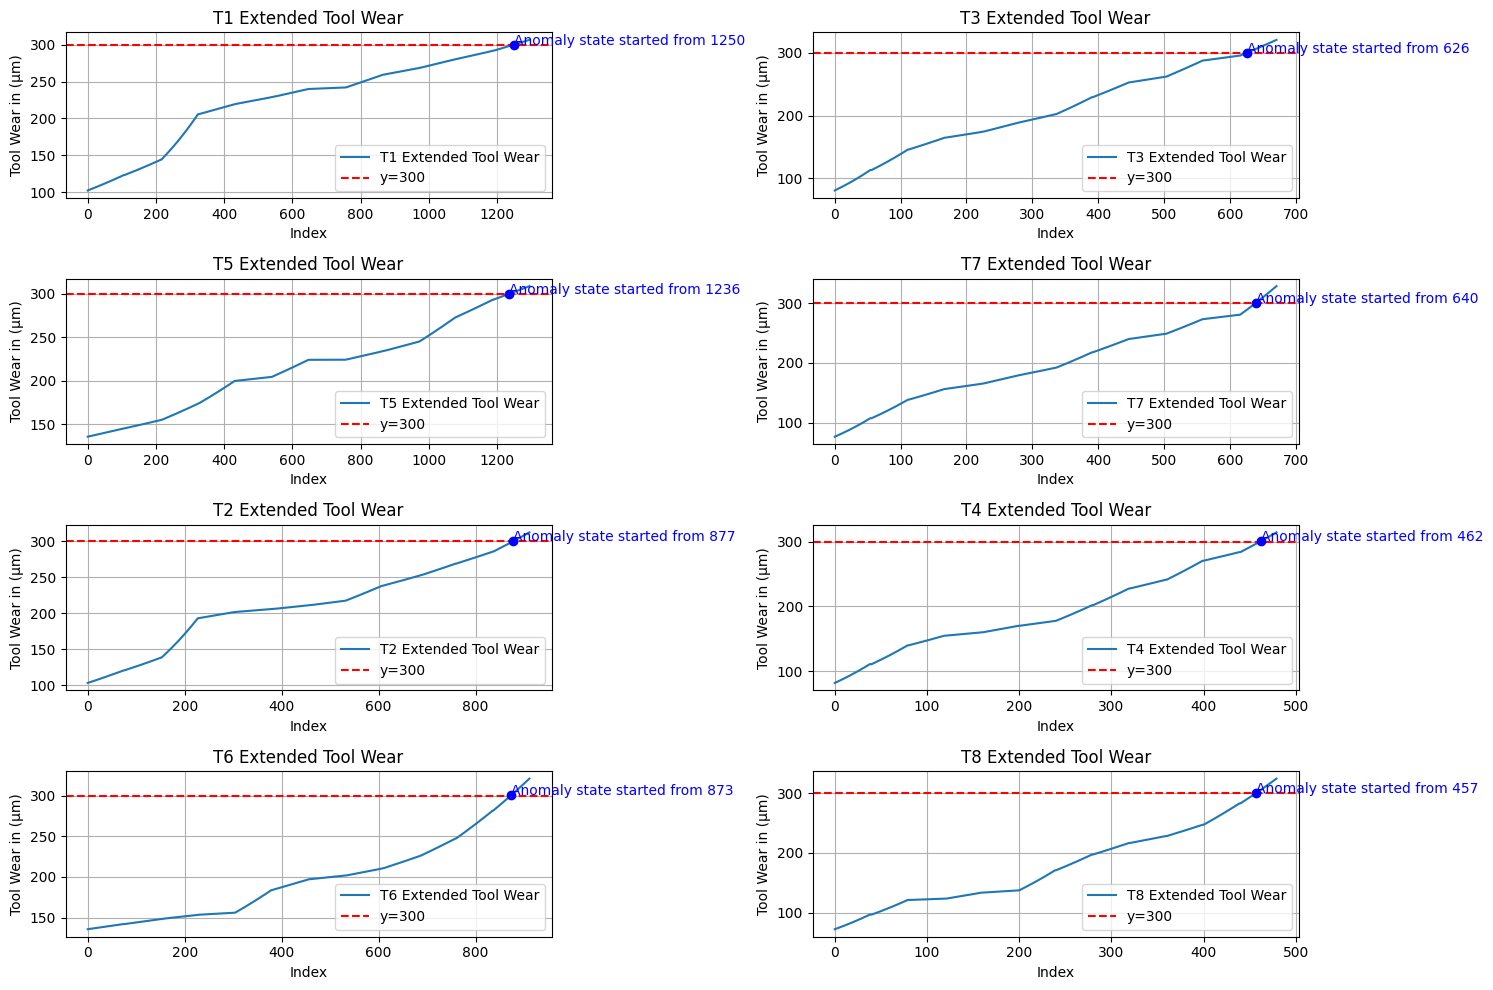

In [ ]:
import matplotlib.pyplot as plt

def visualize_extended_data3(extended_data):
    # Create a figure and 4x2 subplots
    fig, axes = plt.subplots(4, 2, figsize=(15, 10))

    # Custom order for subplots: 1 5, 2 6, 3 7, 4 8
    custom_order = [0,4,1,5,2,6,3,7]
    axes = axes.flatten()  # Flatten the 4x2 grid for easier iteration

    # Iterate through each folder and its corresponding dataframe
    for i, (folder, df) in enumerate(extended_data.items()):
        ax = axes[custom_order[i]]  # Use custom order for plotting

        # Plot the data on the current axis
        ax.plot(df['Tool Wear in (µm)'], label=f'{folder} Extended Tool Wear')

        # Set the title and labels for each subplot
        ax.set_title(f'{folder} Extended Tool Wear', fontsize=12)
        ax.set_xlabel('Index', fontsize=10)
        ax.set_ylabel('Tool Wear in (µm)', fontsize=10)

        # Add a horizontal line at y=300 (dotted line)
        ax.axhline(y=300, color='r', linestyle='--', label='y=300')

        # Find the first point where the value exceeds 300
        exceeding_points = df[df['Tool Wear in (µm)'] > 300]
        if not exceeding_points.empty:
            first_exceeding_index = exceeding_points.index[0]
            first_exceeding_value = exceeding_points.iloc[0]['Tool Wear in (µm)']

            # Mark the first point that exceeds 300
            ax.plot(first_exceeding_index, first_exceeding_value, 'bo')  # Blue marker
            ax.text(first_exceeding_index, first_exceeding_value, f'Anomaly state started from {first_exceeding_index}',
                    fontsize=10, color='blue')  # Display the index

        # Add a legend and grid
        ax.legend()
        ax.grid(True)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage: visualize the extended data
visualize_extended_data3(extended_data2)
